In [78]:
import networkx as nx
import numpy as np
import string
from random import sample
import torch

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [79]:
object_to_code = {}
for i in range(48, 58):
  object_to_code[chr(i)] = i - 48
for i in range(97, 123):
  object_to_code[chr(i)] = i - 87

In [80]:
# G = nx.fast_gnp_random_graph(5, 0.2, directed=True)
# pos = nx.spring_layout(G)
# with plt.xkcd():
#     nx.draw_networkx(G, pos, arrowsize=10, with_labels=True, node_size=1000, node_color='black', edge_color='black',
#                     font_size=15, font_family='Bradley Hand')
#     plt.savefig('graph')

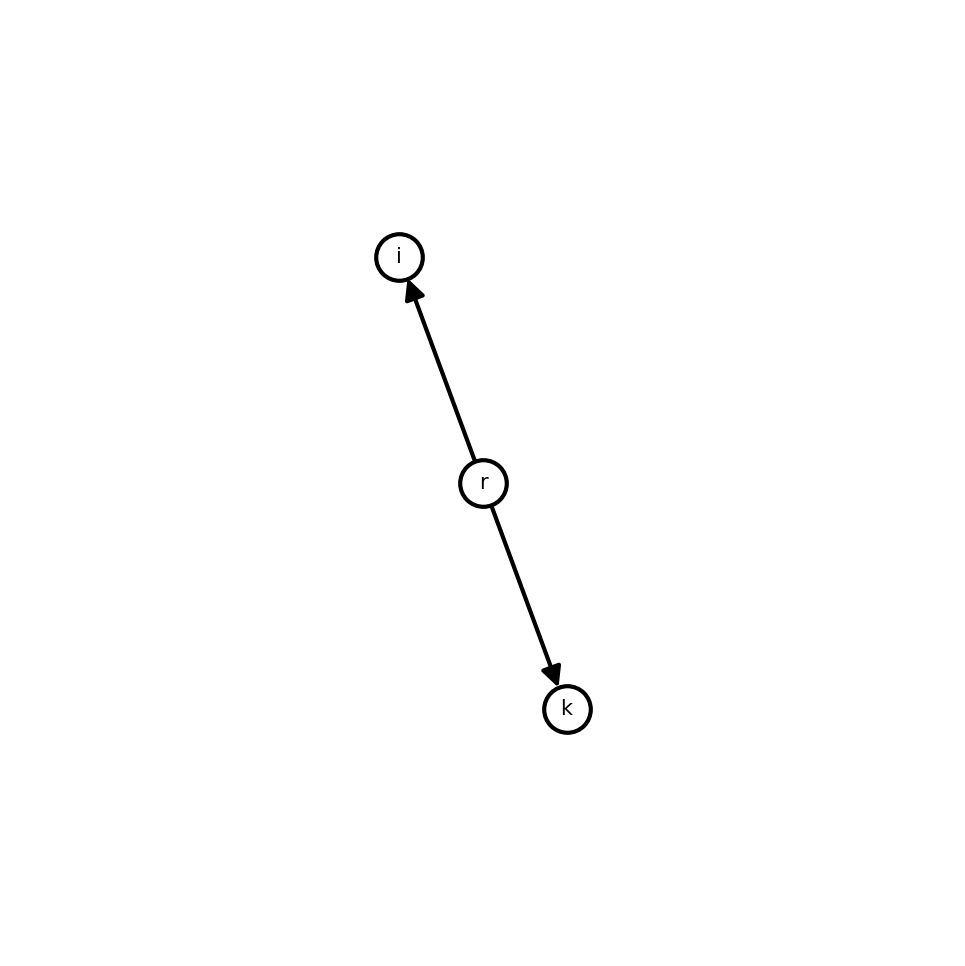

In [81]:
all_labels = list(string.ascii_lowercase) + [chr(num) for num in range(48, 58)]

n = 3
p = .5

# create graph
G = nx.fast_gnp_random_graph(n, p, directed=True)


# relabel nodes
labels = dict(zip(nx.spring_layout(G).keys(), sample(all_labels, n)))
backwards_labels = {labels[key]: key for key in labels}
nx.relabel_nodes(G, labels, copy=False)
G.remove_edges_from(list(nx.selfloop_edges(G)))
adjacency = nx.adjacency_matrix(G).toarray()


# draw graph
options = {
    "font_size": 5,
    "font_family": 'Bradley Hand',
    "node_size": 125,
    # "arrowsize": 25,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
}

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, **options)
# set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.axis("off")
plt.savefig('graph', bbox_inches='tight', pad_inches=0)
plt.show()

In [82]:
labels

{0: 'k', 1: 'r', 2: 'i'}

In [83]:
# Generate bounding box points for training data
radius = [.11 for i in range(n)]
def format_box(x1, y1, x2, y2):
    return [min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2)]

letters_radius = .05
import math

boxes = []
training_labels = []
for k in pos.keys():
    i = backwards_labels[k]
    boxes.append(format_box(pos[k][0] - radius[i], pos[k][1] - radius[i], pos[k][0] + radius[i], pos[k][1] + radius[i]))
    training_labels.append(36)

for k in pos.keys():
  boxes.append(format_box(pos[k][0] - letters_radius, pos[k][1] - letters_radius, pos[k][0] + letters_radius, pos[k][1] + letters_radius))
  if k in object_to_code:
    training_labels.append(object_to_code[k])

for i in range(len(adjacency)):
    for j in range(len(adjacency[i])):
        letter = labels[i]
        letter_2 = labels[j]
        if adjacency[i][j] == 1:
            x1 = pos[letter][0]
            y1 = pos[letter][1]
            x2 = pos[letter_2][0]
            y2 = pos[letter_2][1]

            second_above = y2 > y1
            second_right = x2 > x1
            slope = (y2 - y1) / (x2 - x1)

            x_delta_abs1 = math.sqrt(radius[i]**2 / (1 + slope**2))
            y_delta_abs1 = abs(slope * x_delta_abs1)

            x_delta_abs2 = math.sqrt(radius[j]**2 / (1 + slope**2))
            y_delta_abs2 = abs(slope * x_delta_abs2)

            box_x1 = x1 + x_delta_abs1 if second_right else x1 - x_delta_abs1
            box_y1 = y1 + y_delta_abs1 if second_above else y1 - y_delta_abs1

            box_x2 = x2 - x_delta_abs2 if second_right else x2 + x_delta_abs2
            box_y2 = y2 - y_delta_abs2 if second_above else y2 + y_delta_abs2

            boxes.append(format_box(box_x1, box_y1, box_x2, box_y2))
            
            if second_above and second_right: 
              training_labels.append(40)
            elif second_above and not second_right:
              training_labels.append(42)
            elif not second_above and second_right:
              training_labels.append(43)
            elif not second_above and not second_right:
              training_labels.append(41)

out = {"labels": torch.Tensor([training_labels]), "boxes": torch.Tensor(np.array(boxes))}


In [84]:
pos

{'k': array([ 0.36901975, -0.99999996]),
 'r': array([-1.04520609e-07, -3.85701650e-08]),
 'i': array([-0.36901965,  1.        ])}

In [85]:
out["boxes"]

tensor([[ 0.2590, -1.1100,  0.4790, -0.8900],
        [-0.1100, -0.1100,  0.1100,  0.1100],
        [-0.4790,  0.8900, -0.2590,  1.1100],
        [ 0.3190, -1.0500,  0.4190, -0.9500],
        [-0.0500, -0.0500,  0.0500,  0.0500],
        [-0.4190,  0.9500, -0.3190,  1.0500],
        [ 0.0381, -0.8968,  0.3309, -0.1032],
        [-0.3309,  0.1032, -0.0381,  0.8968]])

In [86]:
# Display bounding boxes
import torch
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms as T
from PIL import Image

img = Image.open('graph.png').convert('RGB')
t = T.functional.convert_image_dtype(T.ToTensor()(img), torch.uint8)


# Transform coordinates
for i in range(len(out["boxes"])):
    out["boxes"][i][0] = t.shape[2] / 2 + out["boxes"][i][0] * t.shape[2] / 4
    out["boxes"][i][2] = t.shape[2] / 2 + out["boxes"][i][2] * t.shape[2] / 4
    temp = t.shape[1] / 2 - out["boxes"][i][1] * t.shape[1] / 4
    out["boxes"][i][1] = t.shape[1] / 2 - out["boxes"][i][3] * t.shape[1] / 4
    out["boxes"][i][3] = temp

out["boxes"]


tensor([[511.1032, 654.5850, 560.8782, 704.4150],
        [427.6125, 428.0850, 477.3875, 477.9150],
        [344.1218, 201.5850, 393.8968, 251.4150],
        [524.6782, 668.1750, 547.3032, 690.8250],
        [441.1875, 441.6750, 463.8125, 464.3250],
        [357.6968, 215.1750, 380.3218, 237.8250],
        [461.1160, 476.3743, 527.3746, 656.1257],
        [377.6254, 249.8743, 443.8839, 429.6257]])

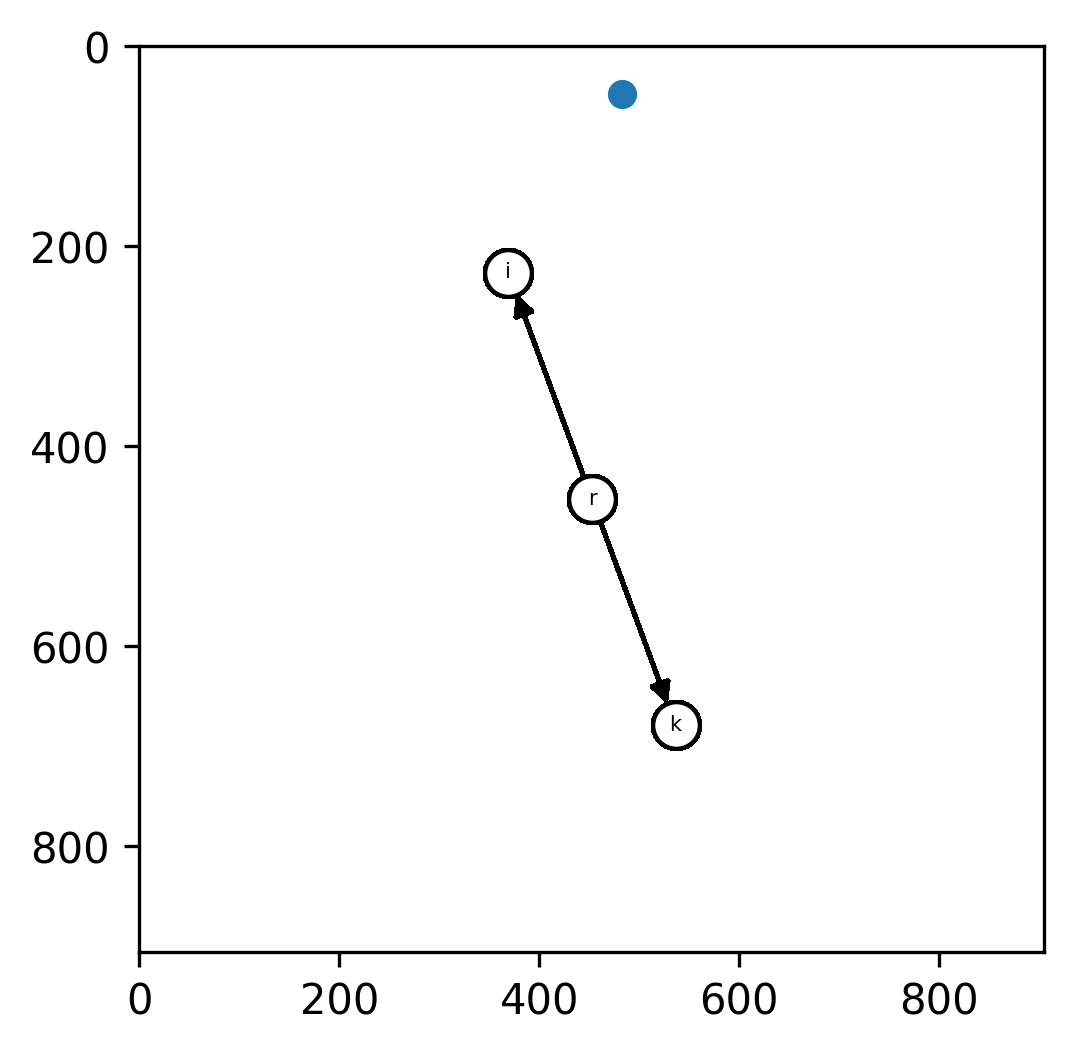

In [87]:
plt.imshow(img)
plt.scatter(482.5000,  48.0000)

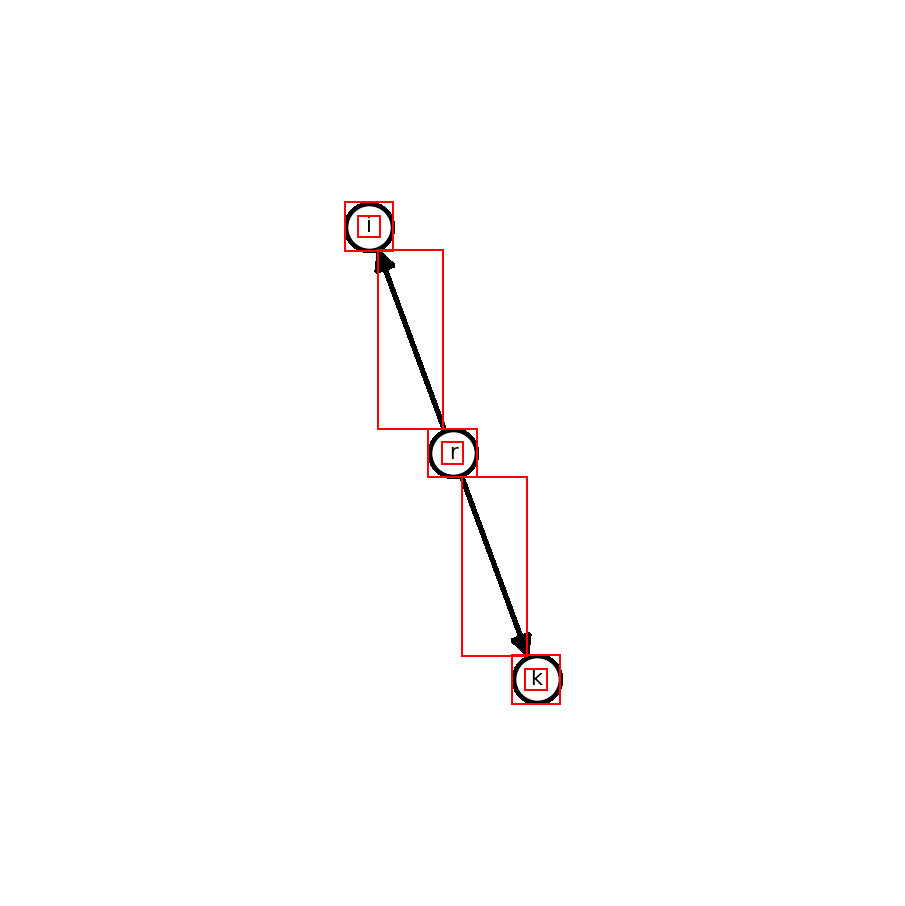

In [88]:
t_boxes = draw_bounding_boxes(t, out["boxes"], colors = 'red', width=2)
img_boxes = T.ToPILImage()(t_boxes)
img_boxes.show()

In [89]:
training_labels

[36, 36, 36, 20, 27, 18, 43, 42]